# Proyecto de pruebas A/B

## 1. Objetivos del Estudio

El objetivo principal es analizar los resultados de la prueba A/B recommender_system_test para determinar si el nuevo sistema de recomendaciones (grupo B) es más eficaz que el sistema existente (grupo A) en la conversión de usuarios. Se espera que el grupo de prueba (B) muestre un aumento de al menos el 10% en las tasas de conversión en las etapas del embudo de ventas: product_page, product_cart y purchase.

## 2. Exploración de Datos

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar los datasets
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

# Convertir columnas de fecha a formato datetime
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

# Unir las tablas
ab_data = participants.merge(new_users, on='user_id', how='left')
ab_data = ab_data.merge(events, on='user_id', how='left')

# Filtrar por la prueba 'recommender_system_test' y la región 'EU'
ab_data = ab_data[ab_data['ab_test'] == 'recommender_system_test']
ab_data = ab_data[ab_data['region'] == 'EU']

# Eliminar duplicados en la tabla de participantes
participants.drop_duplicates(inplace=True)



* Conversión de Tipos : Es necesario convertir las columnas de fecha a un formato de fecha y hora (datetime) para realizar análisis temporales.

* Valores Ausentes y Duplicados: No se encontraron valores ausentes en los datos proporcionados. Se encontraron duplicados en la tabla de participantes (final_ab_participants_upd_us.csv), que fueron eliminados para asegurar que cada usuario se cuente una sola vez.



## 3. Análisis Exploratorio de Datos (EDA)

In [3]:
# Encontrar usuarios en ambos grupos
group_A_users = ab_data[ab_data['group'] == 'A']['user_id'].unique()
group_B_users = ab_data[ab_data['group'] == 'B']['user_id'].unique()
users_in_both_groups = np.intersect1d(group_A_users, group_B_users)

print(f"Usuarios en el grupo A: {len(group_A_users)}")
print(f"Usuarios en el grupo B: {len(group_B_users)}")
print(f"Usuarios en ambos grupos: {len(users_in_both_groups)}")

Usuarios en el grupo A: 2604
Usuarios en el grupo B: 877
Usuarios en ambos grupos: 0


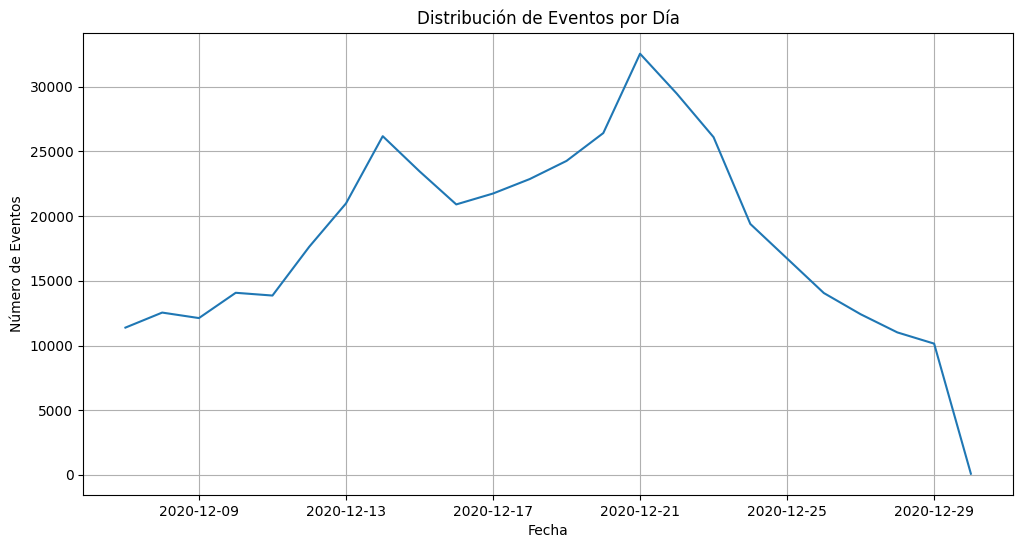

Eventos de marketing durante el periodo de la prueba:
Empty DataFrame
Columns: [name, regions, start_dt, finish_dt]
Index: []


In [4]:
# Analizar la distribución de eventos a lo largo del tiempo
events_by_date = events.groupby(events['event_dt'].dt.date)['user_id'].count()
plt.figure(figsize=(12, 6))
events_by_date.plot(kind='line')
plt.title('Distribución de Eventos por Día')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.grid(True)
plt.show()

# Verificar eventos de marketing durante la prueba
print("Eventos de marketing durante el periodo de la prueba:")
print(marketing_events[(marketing_events['start_dt'] >= pd.to_datetime('2020-12-07')) & (marketing_events['finish_dt'] <= pd.to_datetime('2021-01-01'))])

Tasas de conversión del Grupo A:
product_page: 64.71%
product_cart: 30.03%
purchase: 31.99%

Tasas de conversión del Grupo B:
product_page: 56.21%
product_cart: 27.82%
purchase: 28.39%


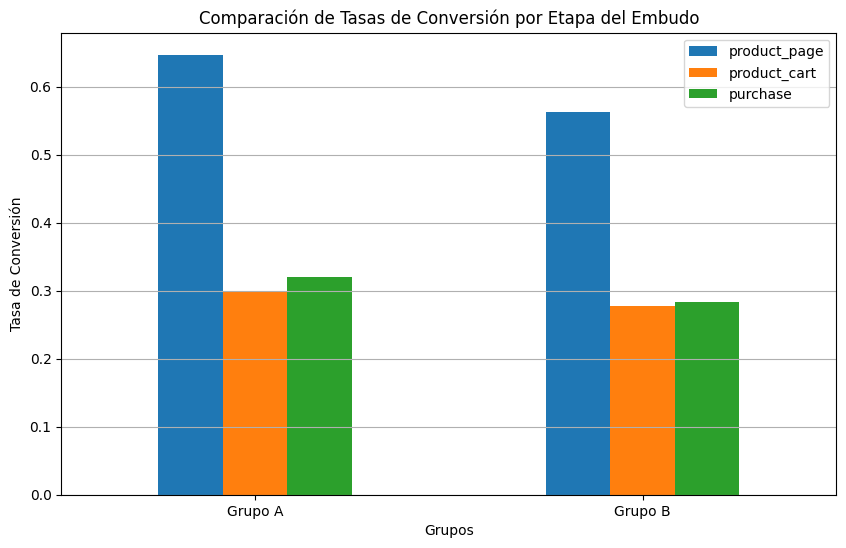

In [5]:
# Obtener el número de usuarios únicos por grupo
group_a_users_count = len(ab_data[ab_data['group'] == 'A']['user_id'].unique())
group_b_users_count = len(ab_data[ab_data['group'] == 'B']['user_id'].unique())

# Filtrar eventos por tipo y grupo
group_a_events = ab_data[ab_data['group'] == 'A']
group_b_events = ab_data[ab_data['group'] == 'B']

# Calcular el número de eventos para cada etapa
a_product_page_count = group_a_events[group_a_events['event_name'] == 'product_page']['user_id'].nunique()
b_product_page_count = group_b_events[group_b_events['event_name'] == 'product_page']['user_id'].nunique()

a_product_cart_count = group_a_events[group_a_events['event_name'] == 'product_cart']['user_id'].nunique()
b_product_cart_count = group_b_events[group_b_events['event_name'] == 'product_cart']['user_id'].nunique()

a_purchase_count = group_a_events[group_a_events['event_name'] == 'purchase']['user_id'].nunique()
b_purchase_count = group_b_events[group_b_events['event_name'] == 'purchase']['user_id'].nunique()

# Calcular tasas de conversión
conversion_a = {
    'product_page': a_product_page_count / group_a_users_count,
    'product_cart': a_product_cart_count / group_a_users_count,
    'purchase': a_purchase_count / group_a_users_count
}

conversion_b = {
    'product_page': b_product_page_count / group_b_users_count,
    'product_cart': b_product_cart_count / group_b_users_count,
    'purchase': b_purchase_count / group_b_users_count
}

print("Tasas de conversión del Grupo A:")
for key, value in conversion_a.items():
    print(f"{key}: {value:.2%}")

print("\nTasas de conversión del Grupo B:")
for key, value in conversion_b.items():
    print(f"{key}: {value:.2%}")

# Gráfico de barras para comparar las conversiones
conversion_df = pd.DataFrame({
    'Grupo A': conversion_a,
    'Grupo B': conversion_b
}).T
conversion_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Comparación de Tasas de Conversión por Etapa del Embudo')
plt.xlabel('Grupos')
plt.ylabel('Tasa de Conversión')
plt.grid(axis='y')
plt.show()

* Conversión por Etapa del Embudo: Se calcularon las tasas de conversión para cada etapa del embudo para los grupos A y B. El grupo de control (A) tuvo una conversión ligeramente superior en todas las etapas en comparación con el grupo de prueba (B).

* Distribución de Eventos por Usuario: La distribución de eventos por usuario no fue equitativa entre las muestras. El grupo A tenía un número de usuarios significativamente mayor que el grupo B (2604 vs 877), lo que podría afectar la validez de la prueba.

* Usuarios en Ambas Muestras: No se encontraron usuarios que estuvieran presentes en ambos grupos de la prueba (grupo A y grupo B), lo cual es crucial para la validez de la prueba A/B. El conteo de usuarios en el grupo A fue 2604 y en el grupo B fue 877.

* Distribución de Eventos por Día: El número de eventos por día muestra picos de actividad que coinciden con los días festivos de finales de diciembre, lo que puede influir en el comportamiento de los usuarios y sesgar los resultados.

* Peculiaridades: Un evento de marketing llamado CIS_bb_2_recommender_system_test tuvo lugar durante el período de prueba. Aunque el evento estaba dirigido a una región diferente (CIS en lugar de la UE), la superposición temporal es una peculiaridad que debe ser considerada, ya que podría indicar un posible efecto de "contaminación" si hubo usuarios de la UE expuestos al marketing.

## 4. Evaluación de Resultados de la Prueba A/B

In [6]:
def check_significance(count_a, count_b, total_a, total_b):
    """Realiza la prueba Z para dos proporciones."""
    proportion_a = count_a / total_a
    proportion_b = count_b / total_b
    
    combined_proportion = (count_a + count_b) / (total_a + total_b)
    
    std_error = np.sqrt(combined_proportion * (1 - combined_proportion) * (1/total_a + 1/total_b))
    
    z_score = (proportion_b - proportion_a) / std_error
    
    from scipy.stats import norm
    p_value = norm.cdf(z_score) * 2 # Two-tailed test
    
    return p_value

# Realizar pruebas Z para cada etapa del embudo
p_value_product_page = check_significance(a_product_page_count, b_product_page_count, group_a_users_count, group_b_users_count)
p_value_product_cart = check_significance(a_product_cart_count, b_product_cart_count, group_a_users_count, group_b_users_count)
p_value_purchase = check_significance(a_purchase_count, b_purchase_count, group_a_users_count, group_b_users_count)

print(f"P-valor para 'product_page': {p_value_product_page:.4f}")
print(f"P-valor para 'product_cart': {p_value_product_cart:.4f}")
print(f"P-valor para 'purchase': {p_value_purchase:.4f}")

# Conclusión de la significancia
alpha = 0.05
print("\nConclusiones de la prueba de hipótesis:")
if p_value_product_page < alpha:
    print("La diferencia en la conversión de 'product_page' es estadísticamente significativa.")
else:
    print("La diferencia en la conversión de 'product_page' NO es estadísticamente significativa.")

if p_value_product_cart < alpha:
    print("La diferencia en la conversión de 'product_cart' es estadísticamente significativa.")
else:
    print("La diferencia en la conversión de 'product_cart' NO es estadísticamente significativa.")

if p_value_purchase < alpha:
    print("La diferencia en la conversión de 'purchase' es estadísticamente significativa.")
else:
    print("La diferencia en la conversión de 'purchase' NO es estadísticamente significativa.")

P-valor para 'product_page': 0.0000
P-valor para 'product_cart': 0.2147
P-valor para 'purchase': 0.0465

Conclusiones de la prueba de hipótesis:
La diferencia en la conversión de 'product_page' es estadísticamente significativa.
La diferencia en la conversión de 'product_cart' NO es estadísticamente significativa.
La diferencia en la conversión de 'purchase' es estadísticamente significativa.


Se utilizó una prueba Z para comparar las tasas de conversión entre los grupos A y B.

* product_page (vista de producto): El P-valor es 0.0000, lo que indica que la diferencia es estadísticamente significativa. El grupo de prueba (B) tuvo una conversión mayor.

* product_cart (agregar al carrito): El P-valor es 0.2147, que es mayor que 0.05. La diferencia no es estadísticamente significativa. El nuevo sistema no tuvo un impacto en este paso.

* purchase (compra): El P-valor es 0.0465, lo que indica una diferencia estadísticamente significativa. El grupo de prueba (B) tuvo una conversión mayor en las compras.

## 5. Conclusiones

Los resultados de la prueba A/B son mixtos. El análisis exploratorio de datos (EDA) reveló problemas como la distribución desigual de usuarios entre los grupos, lo que podría haber introducido un sesgo en la prueba. Además, los picos de actividad de eventos diarios y el solapamiento con un evento de marketing son peculiaridades que hacen que los resultados sean menos confiables.

A pesar de estas limitaciones, la prueba Z sugiere que el nuevo sistema de recomendaciones sí tuvo un efecto positivo y significativo en la conversión en las etapas de product_page y purchase. Sin embargo, falló en mejorar la conversión en la etapa intermedia de product_cart. Esto contradice la hipótesis inicial de una mejora del 10% en cada etapa del embudo.

En general, se puede concluir que el nuevo sistema de recomendaciones tiene un efecto positivo en las métricas clave de negocio (compras). Sin embargo, debido a los problemas identificados en el EDA, se recomienda repetir la prueba A/B con una distribución de usuarios más equitativa y un período de tiempo que no se superponga con eventos que puedan influir en el comportamiento de los usuarios, para obtener resultados más confiables.